# Calibration of Imbalance weights $w$, LOB Price Deviation $dp^+$ as well as Market Order Price Impact $dq$

## Preparation of Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import minimize, Bounds
from datetime import datetime
from bisect import bisect_left
import mystic
from mystic.symbolic import generate_constraint, generate_solvers, generate_penalty, generate_conditions, simplify
from mystic.monitors import VerboseMonitor
from mystic.solvers import diffev2, fmin_powell
from random import choices
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

In [2]:
#Import the data
#Unzip the datafile before loading
lob = pd.read_csv('./data/20170417_AEM_limit_order_book.csv')
lob.head()

,time,time_nanos,symbol,venue,side,book_change,price,reason,market_state,pa0,...,va7,vb7,pa8,pb8,va8,vb8,pa9,pb9,va9,vb9
0,2017-04-17 09:30:00,3886390.0,AEM,TSE,Buy,-100.0,62.0,TRADE,Opening,62.0,...,200.0,0.0,62.08,61.92,0.0,0.0,62.09,61.91,0.0,100.0
1,2017-04-17 09:30:00,3886390.0,AEM,TSE,Sell,-100.0,62.0,TRADE,Opening,62.0,...,200.0,0.0,62.08,61.92,0.0,0.0,62.09,61.91,0.0,100.0
2,2017-04-17 09:30:00,3886395.0,AEM,TSE,Buy,-100.0,62.0,TRADE,Opening,62.0,...,200.0,0.0,62.08,61.92,0.0,0.0,62.09,61.91,0.0,100.0
3,2017-04-17 09:30:00,3886395.0,AEM,TSE,Sell,-100.0,62.0,TRADE,Opening,62.0,...,200.0,0.0,62.08,61.92,0.0,0.0,62.09,61.91,0.0,100.0
4,2017-04-17 09:30:00,3886400.0,AEM,TSE,Sell,-100.0,62.0,TRADE,Opening,62.0,...,200.0,0.0,62.08,61.92,0.0,0.0,62.09,61.91,0.0,100.0


In [3]:
#For resampling reasons, we convert the time in seconds.nanosc to prepare for calibration
lob['time'] = pd.to_datetime(lob['time']).apply(lambda x: (x - datetime(1970,1,1)).total_seconds())
lob['time'] = lob['time'] + 1e-9  * lob['time_nanos']
lob.sort_values('time', inplace=True)

#Transform unit of price into ticks
name_ask = ['pa' + str(i) for i in range(10)]
name_bid = ['pb' + str(i) for i in range(10)]
lob[name_ask] = 100 * lob[name_ask]
lob[name_bid] = 100 * lob[name_bid]

## Optimal depth and sample frequenty

We sample the data every $f$ seconds and compute best ask price change as $dp_a(t) = p_a(t) - p_a(t-f)$.
The sampling frequency is 
\begin{equation*}
    \mathop{\arg\min}\limits_{f > 0} |\sigma^2 - \sigma_f^2 |     
\end{equation*}
when $\sigma_f^2$ , the variance of $dp_a$ is the closest to a given benchmark variance $\sigma^2 = 2$.

In [4]:
def takeClosest(myList, myNumber):
    #Assumes myList is sorted. Returns closest value to myNumber.
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return pos
    if pos == len(myList):
        return -1
    before = myList[pos - 1]
    after = myList[pos]
    #If two numbers are equally close, return the smallest number.  
    if after - myNumber < myNumber - before:
        return pos
    else:
        return pos-1
    
def get_frequency(nums, day, lob):
    #Slice the trading day into nums seconds intervals
    s = np.array(list(map(lambda x: (x - datetime(1970,1,1)).total_seconds(), pd.date_range(start= day + ' 13:30:00', end=day + ' 20:00:00', freq= str(nums) + 'S'))))
    s1 = np.array(s) - nums
    
    #Since some intervals might not include orders, approximate them by taking the closest trading time in the data
    time_ls = list(lob['time'].values)
    pointer1 = [takeClosest(time_ls, i) for i in s1]
    pointer2 = [takeClosest(time_ls, i) for i in s]
    
    #Compute the price change dpa 
    d = lob['pa0'].values[pointer2] - lob['pa0'].values[pointer1] 
    d = d[np.where(d != None)]
    return np.abs(2 - np.var(d)) 

In [5]:
#Give the date
day = '2017-04-17'
#Find the optimal sampling frequency between 1 second to 360 seconds
x = np.array(range(1,360))
y = np.array([get_frequency(i,day, lob) for i in x])
nums = x[y == y.min()][0]
print(nums)

28


In [ ]:
#Plot the Figure
fig = go.Figure()
fig.add_scatter(x = x, y = y)
fig.update_yaxes(title = r'$|\sigma^2 - \sigma_f^2 | $')
fig.update_xaxes(title = r'$f$')
iplot(fig)

Sample the data every $f$ seconds and since some intervals might not include orders, approximate them by taking the closest trading time in the data.

Compute depth $N$ as the 99\% quantile of empirical sampled price change distribution.

In [6]:
s = np.array(list(map(lambda x: (x - datetime(1970,1,1)).total_seconds(), pd.date_range(start= day + ' 13:30:00', end=day + ' 20:00:00', freq= str(nums) + 'S'))))
s1 = np.array(s) - nums
time_ls = list(lob['time'].values)
pointer1 = [takeClosest(time_ls, i) for i in s1]
pointer2 = [takeClosest(time_ls, i) for i in s]
dp_a = lob['pa0'].values[pointer2] - lob['pa0'].values[pointer1]
N = int(np.quantile(dp_a, 0.99))

In [ ]:
#Plot the histogram of empirial dp
fig = go.Figure()
fig.add_histogram(x = dp_a, histnorm = 'probability')
iplot(fig)

## Compute the weights $w$ as well as $dp^+$ from imbalance, and maximum likelihood.

Compute the average imbalance
\begin{equation*}
    \hat{\imath}(w, t) 
    = \frac{
        \sum\limits_{k\leq N} w_k \bar{v}^b_k (t) 
        }
        {\sum\limits_{k\leq N}  w_k \left(\bar{v}^b_k (t) + \bar{v}^a_k (t) \right)
        }
\end{equation*}
which sums up order book volumes within a certain time interval weighted by time difference
\begin{align*}
    &\bar{v}^a_k(t) = \sum\limits_{t - f \leq s<t} v_k^a(s) \Delta s\\
    &\bar{v}^b_k(t) = \sum\limits_{t - f \leq s<t} v_k^b(s) \Delta s
\end{align*}
and $\Delta s_i = s_{i+1} - s_{i}$.


In [7]:
#Functions to compute the imbalance
def sum_limit_order_book(x, pointer1, pointer2, lmo_volume):
    left = pointer1[x]
    right = pointer2[x]
    if left >= right:
        return np.zeros(N)
    lmo_sum = np.sum(lmo_volume[left:right,:] , axis = 0)  
    return lmo_sum.tolist()

def imbalance_generate(x, weight, N, ask_sum, bid_sum):
    weight = np.array(weight)
    if np.sum(ask_sum[x]) == None:
        return
    B = np.sum(weight * ask_sum[x] + weight * bid_sum[x])
    A =  np.sum(weight * (bid_sum[x]))
    if B == 0:
        return
    return A / B

In [8]:
#Compute time delta between two orders
delta_s = np.diff(time_ls).tolist()
delta_s.insert(0 ,0)
lob['time_diff'] = delta_s 

#Weigh the book volume by time delta
for i in range(1, N+1):
    name_a = 'va' + str(i) 
    name_b = 'vb' + str(i) 
    name_aa = 'va-' + str(i) 
    name_bb = 'vb-' + str(i)
    lob[name_aa] = lob[name_a] * lob['time_diff']
    lob[name_bb] = lob[name_b] * lob['time_diff']

#Sum up the weighted limit order book within f seconds interval
name_ask = ['va-' + str(i) for i in range(1, N+1)]
name_bid = ['vb-' + str(i) for i in range(1, N+1)]
volume_ask = np.array(lob[name_ask])
volume_bid = np.array(lob[name_bid])
ask_sum = list(map(lambda x: sum_limit_order_book(x, pointer1, pointer2, volume_ask), range(len(pointer1))))
bid_sum = list(map(lambda x: sum_limit_order_book(x, pointer1, pointer2, volume_bid), range(len(pointer1))))

Maximize the log likelihood function
\begin{equation}
   \max_{dp^+,w} \frac{1}{M} \sum^M_{m=1} \log p\left(x_m,  \hat{\imath}_m \right)
\end{equation}
where $x_m$ is the empirical price change, $\hat{\imath}_m$ the average imbalance for a given weight $w$, 
\begin{equation*}
    p\left(x_m,  \hat{\imath}_m \right) = dp_{x_m}\left(\hat{\imath}_m \right) p(\hat{\imath}_m)
\end{equation*}
where 
\begin{equation*}
    dp_{x_m} \left(\hat{\imath}_m\right) = \hat{\imath}_m dp^+_{x_m} + \left( 1-\hat{\imath}_m \right) dp^-_{x_m}
\end{equation*}
represents the conditional probability of price change equal to $x_m$ given $\hat{\imath}_m$, and $p(\hat{\imath}_m)$ is the density of the fitted skewnormal distribution evaluated at $\hat{\imath}_m$. 

Give the constraints that
\begin{align*}
     &\sum\limits _{k=1}^N w_k = 1\\
    &\sum\limits _{k=-N}^N dp^+_k = 1
\end{align*}

In [9]:
#Functions of the computation of maximum likelihood
def likelihood(dp_plus, p_I, w, N):
    l = []
    for i in range(2 * N + 1):
        idx = np.where((w[:,1] >= (- N + i)) & (w[:,1] <  (- N + i + 1)))
        X1 = w[idx][:,0]
        X2 = 1 - w[idx][:,0]
        l = np.append(l, (dp_plus[i] * X1 + dp_plus[2 * N - i] * X2) * np.array(p_I)[idx])
    l = np.array(l)[~np.isnan(l)]
    l = l[l>0]
    return - np.sum(np.log(l)) / len(l)

def bayes(x):
    dp_plus = x[N:]
    weight = x[0:N] 
    #Compute avergae imbalance
    imb = list(map(lambda x: imbalance_generate(x, weight, N, ask_sum, bid_sum), range(len(ask_sum))))
    #Concatenate the imblance array with dp_a
    w = np.append(np.array(imb).reshape(len(imb),1), np.array(dp_a).reshape(len(imb),1), axis = 1)
    w = np.array(w[w[:,0] != None]).astype(float)
    w = np.array(w[~np.isnan(w[:,0])])
    #Fit the imbalance into skewnormal distribution abd compute the probability
    a, loc, scale = skewnorm.fit(w[:,0])
    p_I = skewnorm.pdf(w[:,0], a = a, scale = scale, loc = loc)
    return likelihood(dp_plus, p_I, w, N)

## Run the computation of maximum likelihood (takes 5mn)

In [10]:
#Constraints
equations = '+'.join('x' + str(i) for i in range(N)) + '==1' + '\n' + '+'.join('x' + str(i) for i in range(N,2*N+5)) + '==1'
cf = generate_constraint(generate_solvers(simplify(equations)))
pf = generate_penalty(generate_conditions(equations), k=1e12)
bnds = [(0,1)] * (N + 2 * N + 1)
mon = VerboseMonitor(100)
x0 =  np.random.uniform(0,1,(2 * N + 1 + N))
#Initial weights
x0[:N] = x0[:N] / x0[:N].sum() 
#Initial dp_plus
x0[N:] = x0[N:] / x0[N:].sum()
#We can test this part serveral times to get a closer solution to global minimum
result = diffev2(bayes, x0 = x0, bounds = bnds, constraints=cf, penalty=pf, disp = True, full_output=True, itermon=mon, ftol = 1e-8)
#Optimize locally 
result = fmin_powell(bayes, x0 = result[0], bounds = bnds, constraints=cf, penalty=pf, disp = True, full_output=True, ftol = 1e-8)

Generation 0 has ChiSquare: 1.156092
Generation 100 has ChiSquare: 0.761021
STOP("VTRChangeOverGeneration with {'ftol': 1e-08, 'gtol': 1e-06, 'generations': 30, 'target': 0.0}")
Optimization terminated successfully.
         Current function value: 0.758109
         Iterations: 156
         Function evaluations: 2041
Optimization terminated successfully.
         Current function value: 0.758034
         Iterations: 3
         Function evaluations: 961


In [33]:
#Using this method, the optimal weights are stable, however for dp_plus not. So we set weigths and repeat the optimization with repsect to dp_plus
weight = result[0][:N]
imb = list(map(lambda x: imbalance_generate(x, weight, N, ask_sum, bid_sum), range(len(ask_sum))))
w = np.append(np.array(imb).reshape(len(imb),1), np.array(dp_a).reshape(len(imb),1), axis = 1)
w = np.array(w[w[:,0] != None]).astype(float)
w = np.array(w[~np.isnan(w[:,0])])
a, loc, scale = skewnorm.fit(w[:,0])
p_I = skewnorm.pdf(w[:,0], a = a, scale = scale, loc = loc)
x0 = result[0][N:]
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
result1 = minimize(likelihood, x0, constraints = cons, bounds = Bounds(0,1), args = (p_I, w, N)) 

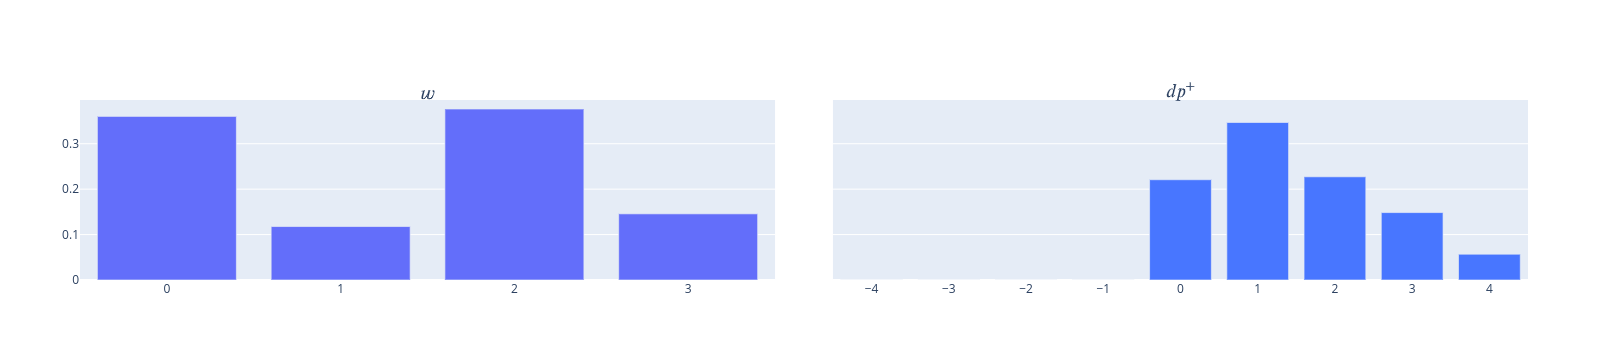

In [34]:
#Plot the weights and dp_plus
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.04, shared_yaxes=True, subplot_titles= (r'$w$',r'$dp^+$'))
fig.add_bar(x = np.arange(N), y = result[0][:N],row = 1, col = 1, showlegend = False)
fig.add_bar(x = np.arange(-N,N+1), y = result1.x, marker_color='#4876FF',row = 1, col = 2, showlegend = False)
fig.update_xaxes(dtick = 1)
iplot(fig)

## Compute Market Orders Price Impact $dq$
$dq$ is the probability that the price moves by $k$ ticks triggered by market orders.
Thus for each market order, compute
\begin{equation*}
    F(H) = \inf \{ x\in \mathbb{N}_0 : \sum_{k=0}^x v_k \geq H\}
\end{equation*}
where $H$ is the volume of the market order. We derive $dq$ from the empirical distribution.

In [ ]:
#Compute the total market order volumes within the intervals
def sum_H_generate(x, pointer1, pointer2, H):
    left = pointer1[x]
    right = pointer2[x]
    if left >= right:
        return
    h = np.sum(H[left:right])
    return h

#Extract all the market orders
m = lob.loc[(lob['reason'] == 'TRADE') & (lob['side'] == 'Buy') & (lob['market_state'] == 'Opening') | (lob['reason'] == 'TRADE') & (lob['side'] == 'Sell') & (lob['market_state'] == 'Open') ]
time_ls = list(m['time'].values)
pointer1 = np.array([takeClosest(time_ls, i) for i in s1])
pointer2 = np.array([takeClosest(time_ls, i) for i in s])
pointer3 = pointer1[np.where((pointer1 - pointer2)!=0)[0]]
pointer4 = pointer2[np.where((pointer1 - pointer2)!=0)[0]]
#Compute the empirical distribution of H 
H = np.array(list(map(lambda x: sum_H_generate(x, pointer3, pointer4, - m['book_change'].values), range(len(pointer3)))) )
H = H[np.where(H != None)]
#Set the upper bound of distribution of H as its 95% quantile and derive H range for simaulation
H_em = np.zeros(int(np.quantile(H,0.95)/100))
for i in range(len(H_em)):
    H_em[i] = len(H[(i * 100 < H) & (H <= (i+1) * 100)]) / len(H)
H = 100 * np.arange(int(np.quantile(H, 0.95) / 100))

In [ ]:
#Since dq is in [-N,N] and by the definition of F(H), we have to consider limit order book 2 ticks deeper.
N = N + 2
#The inverse of cumulative sum of limit order book at H
def inv(v, H):
    s = 0
    if H >= np.sum(v):
        return N
    for i in range(0,len(v)):
        s = s + v[i]
        if s > H:
            return i
        if s == H:
            return i + 1
        
#Use monte carlo to simulate F(H) for each limit order book
def q_simulation(df, H, H_em):
    #HH = H[H <= np.sum(df)]
    H_sample = choices(H, H_em, k = 100)
    l = np.array(list(map(lambda x : inv(df,x), H_sample)))
    return l 
name_ask = ['va' + str(i) for i in range(1, N + 1)]
df = lob[name_ask].values
data = np.array(list(map(lambda x: q_simulation(df[x], H, H_em), range(len(df)))))

In [ ]:
#Compute dq 
data = np.concatenate(data)
data = data[data != None]
qq = np.zeros(N)
for i in range(0, N):
    qq[i] = len(data[data >= i]) / len(data)
dq = np.zeros(2 * N -1)
dq[:N - 1] = qq[1 : N][::-1]
dq[N:] = qq[1:N]
dq[N - 1] = 2 * qq[0]
dq= dq / np.sum(dq)
dq = dq[1:len(dq)-1] 
dq